## 1. Understanding the Paper's Key Contributions
The paper introduced:

*   Encoder-Decoder architecture with LSTMs
*   Reversing the input sequence (important trick!)
*   Using deep LSTMs (4 layers)
*   Teacher forcing during training





In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## 2. Data preparation

In [2]:
# Create a simple dataset - reversing sequences
def generate_data(num_samples, min_len=3, max_len=10):
    samples = []
    for _ in range(num_samples):
        length = random.randint(min_len, max_len)
        # Create random sequence of digits
        input_seq = [str(random.randint(0, 9)) for _ in range(length)]
        # Target is the reversed sequence
        target_seq = input_seq[::-1]
        samples.append((''.join(input_seq), ''.join(target_seq)))
    return samples

# Generate training and test data
train_data = generate_data(5000)
test_data = generate_data(1000)

print("Sample training examples:")
for i in range(3):
    print(f"Input: {train_data[i][0]} -> Target: {train_data[i][1]}")

Sample training examples:
Input: 873260 -> Target: 062378
Input: 980370 -> Target: 073089
Input: 739143 -> Target: 341937


##2. Vocabulary and data processing

In [3]:
class Vocabulary:
    def __init__(self):
        self.char2idx = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2}
        self.idx2char = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>'}
        self.vocab_size = 3

    def build_vocab(self, sequences):
        """Build vocabulary from list of sequences"""
        chars = set()
        for seq in sequences:
            chars.update(seq)

        for char in sorted(chars):
            if char not in self.char2idx:
                self.char2idx[char] = self.vocab_size
                self.idx2char[self.vocab_size] = char
                self.vocab_size += 1

    def encode(self, sequence):
        """Convert sequence to indices"""
        return [self.char2idx[char] for char in sequence]

    def decode(self, indices):
        """Convert indices to sequence"""
        return ''.join([self.idx2char[idx] for idx in indices if idx not in [0, 1, 2]])

# Build vocabulary
source_vocab = Vocabulary()
target_vocab = Vocabulary()

all_source = [seq[0] for seq in train_data + test_data]
all_target = [seq[1] for seq in train_data + test_data]

source_vocab.build_vocab(all_source)
target_vocab.build_vocab(all_target)

print(f"Source vocabulary size: {source_vocab.vocab_size}")
print(f"Target vocabulary size: {target_vocab.vocab_size}")

Source vocabulary size: 13
Target vocabulary size: 13


##4. Dataset class

In [4]:
class ReverseDataset(Dataset):
    def __init__(self, data, source_vocab, target_vocab, reverse_input=True):
        self.data = data
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        self.reverse_input = reverse_input  # Paper's key trick!

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source, target = self.data[idx]

        # Apply the paper's trick: reverse input sequence
        if self.reverse_input:
            source = source[::-1]

        # Encode sequences
        source_encoded = [self.source_vocab.char2idx[char] for char in source]
        target_encoded = [self.target_vocab.char2idx[char] for char in target]

        # Add SOS and EOS tokens to target
        target_encoded = [self.target_vocab.char2idx['<SOS>']] + target_encoded + [self.target_vocab.char2idx['<EOS>']]

        return (
            torch.tensor(source_encoded, dtype=torch.long),
            torch.tensor(target_encoded, dtype=torch.long),
            len(source_encoded),
            len(target_encoded)
        )

def collate_fn(batch):
    """Custom collate function to handle variable length sequences"""
    sources, targets, source_lens, target_lens = zip(*batch)

    # Pad sequences
    sources_padded = torch.nn.utils.rnn.pad_sequence(sources, batch_first=True, padding_value=0)
    targets_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=0)

    return sources_padded, targets_padded, torch.tensor(source_lens), torch.tensor(target_lens)

# Create datasets and dataloaders
train_dataset = ReverseDataset(train_data, source_vocab, target_vocab, reverse_input=True)
test_dataset = ReverseDataset(test_data, source_vocab, target_vocab, reverse_input=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Let's check a batch
for batch in train_loader:
    sources, targets, source_lens, target_lens = batch
    print(f"Batch source shape: {sources.shape}")
    print(f"Batch target shape: {targets.shape}")
    print(f"Source lengths: {source_lens[:5]}")
    print(f"Target lengths: {target_lens[:5]}")
    break

Batch source shape: torch.Size([32, 10])
Batch target shape: torch.Size([32, 12])
Source lengths: tensor([10, 10,  9,  7,  3])
Target lengths: tensor([12, 12, 11,  9,  5])


##5. Encoder Implementation

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=4, dropout=0.3):
        """
        Encoder with LSTM
        Args:
            input_size: vocabulary size
            hidden_size: hidden dimension
            num_layers: number of LSTM layers (paper uses 4)
            dropout: dropout rate
        """
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)

        # LSTM layers - using 4 layers as in the paper
        self.lstm = nn.LSTM(
            hidden_size,
            hidden_size,
            num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, lengths):
        # x shape: (batch_size, seq_len)
        batch_size = x.size(0)

        # Embedding
        embedded = self.dropout_layer(self.embedding(x))
        # embedded shape: (batch_size, seq_len, hidden_size)

        # Pack padded sequences
        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM forward pass
        packed_outputs, (hidden, cell) = self.lstm(packed_embedded)

        # Unpack outputs
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        return outputs, hidden, cell

##6. Decoder Implementation

In [6]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers=4, dropout=0.3):
        """
        Decoder with LSTM
        Args:
            output_size: target vocabulary size
            hidden_size: hidden dimension (should match encoder)
            num_layers: number of LSTM layers
            dropout: dropout rate
        """
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        # Embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)

        # LSTM layers
        self.lstm = nn.LSTM(
            hidden_size,
            hidden_size,
            num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Output layer
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        # x shape: (batch_size, 1) - single token at a time
        # hidden, cell shapes: (num_layers, batch_size, hidden_size)

        # Embedding
        embedded = self.dropout_layer(self.embedding(x))
        # embedded shape: (batch_size, 1, hidden_size)

        # LSTM forward pass
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output shape: (batch_size, 1, hidden_size)

        # Prediction
        prediction = self.fc_out(output.squeeze(1))
        # prediction shape: (batch_size, output_size)

        return prediction, hidden, cell

##7. Seq2Seq Model

In [7]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, source_lengths, teacher_forcing_ratio=0.5):
        """
        Forward pass with teacher forcing
        Args:
            source: source sequences (batch_size, source_len)
            target: target sequences (batch_size, target_len)
            source_lengths: lengths of source sequences
            teacher_forcing_ratio: probability of using teacher forcing
        """
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(self.device)

        # Encoder forward pass
        encoder_outputs, hidden, cell = self.encoder(source, source_lengths)

        # First input to decoder is SOS token
        decoder_input = target[:, 0].unsqueeze(1)  # (batch_size, 1)

        for t in range(1, target_len):
            # Decoder forward pass
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)

            # Store prediction
            outputs[:, t] = output

            # Decide whether to use teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio

            # Get the highest predicted token
            top1 = output.argmax(1)

            # Apply teacher forcing
            decoder_input = target[:, t].unsqueeze(1) if teacher_force else top1.unsqueeze(1)

        return outputs

##8.Training Setup

In [8]:
# Hyperparameters (following paper as much as possible)
INPUT_SIZE = source_vocab.vocab_size
OUTPUT_SIZE = target_vocab.vocab_size
HIDDEN_SIZE = 256  # Paper uses 1000, but reduced for this example
NUM_LAYERS = 4
DROPOUT = 0.3
LEARNING_RATE = 0.001

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize models
encoder = Encoder(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function (ignore padding index)
criterion = nn.CrossEntropyLoss(ignore_index=0)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda
Model parameters: 4,220,685


##9.Training Loop

In [9]:
def train_epoch(model, dataloader, optimizer, criterion, clip=1.0):
    model.train()
    epoch_loss = 0

    for i, (source, target, source_lens, target_lens) in enumerate(dataloader):
        source, target = source.to(device), target.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(source, target, source_lens, teacher_forcing_ratio=0.5)

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Skip SOS token
        target = target[:, 1:].reshape(-1)  # Skip SOS token

        # Calculate loss
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        # Gradient clipping (as mentioned in paper)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for source, target, source_lens, target_lens in dataloader:
            source, target = source.to(device), target.to(device)

            # Forward pass without teacher forcing
            output = model(source, target, source_lens, teacher_forcing_ratio=0)

            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            target = target[:, 1:].reshape(-1)

            loss = criterion(output, target)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

# Training history
train_losses = []
val_losses = []

##10. Training Execution

Starting training...
Epoch: 01
	Train Loss: 1.789
	Val Loss: 1.238
Epoch: 02
	Train Loss: 0.934
	Val Loss: 0.687
Epoch: 03
	Train Loss: 0.560
	Val Loss: 0.417
Epoch: 04
	Train Loss: 0.352
	Val Loss: 0.297
Epoch: 05
	Train Loss: 0.250
	Val Loss: 0.218
Epoch: 06
	Train Loss: 0.185
	Val Loss: 0.171
Epoch: 07
	Train Loss: 0.139
	Val Loss: 0.135
Epoch: 08
	Train Loss: 0.116
	Val Loss: 0.121
Epoch: 09
	Train Loss: 0.081
	Val Loss: 0.109
Epoch: 10
	Train Loss: 0.083
	Val Loss: 0.094


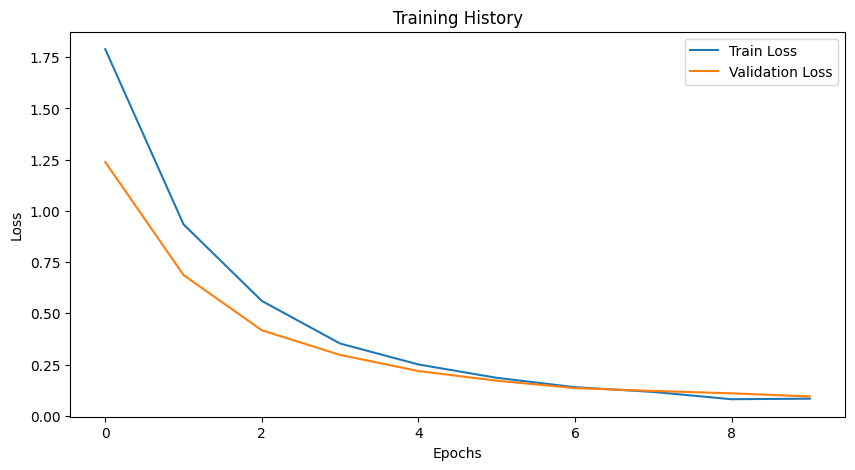

In [10]:
NUM_EPOCHS = 10

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, test_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tVal Loss: {val_loss:.3f}')

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()

##11. Inference Function

In [11]:
def translate(model, sequence, source_vocab, target_vocab, max_length=20, reverse_input=True):
    model.eval()

    # Reverse input as in paper
    if reverse_input:
        sequence = sequence[::-1]

    # Encode sequence
    encoded = [source_vocab.char2idx[char] for char in sequence]
    encoded = torch.tensor(encoded).unsqueeze(0).to(device)  # Add batch dimension
    source_length = torch.tensor([len(encoded[0])])

    with torch.no_grad():
        # Encode
        encoder_outputs, hidden, cell = model.encoder(encoded, source_length)

        # Start with SOS token
        decoder_input = torch.tensor([[target_vocab.char2idx['<SOS>']]]).to(device)

        decoded_tokens = []

        for _ in range(max_length):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell)

            # Get most likely token
            predicted_token = output.argmax(1).item()

            # Stop if EOS token
            if predicted_token == target_vocab.char2idx['<EOS>']:
                break

            decoded_tokens.append(predicted_token)
            decoder_input = torch.tensor([[predicted_token]]).to(device)

    # Decode tokens
    decoded_sequence = target_vocab.decode(decoded_tokens)

    return decoded_sequence

# Test the model
print("\nTesting translation:")
test_examples = test_data[:5]
for source, target in test_examples:
    predicted = translate(model, source, source_vocab, target_vocab)
    print(f"Input: {source} -> True: {target} -> Pred: {predicted}")

# Calculate accuracy
def calculate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for source, target, source_lens, target_lens in dataloader:
            source, target = source.to(device), target.to(device)

            output = model(source, target, source_lens, teacher_forcing_ratio=0)

            # Get predictions
            predictions = output.argmax(-1)

            # Compare with targets (ignore SOS token)
            for i in range(len(predictions)):
                pred_seq = predictions[i, 1:target_lens[i]-1]  # Remove SOS and EOS
                true_seq = target[i, 1:target_lens[i]-1]

                if torch.equal(pred_seq, true_seq):
                    correct += 1
                total += 1

    return correct / total

accuracy = calculate_accuracy(model, test_loader)
print(f"\nTest Accuracy: {accuracy:.2%}")


Testing translation:
Input: 893996 -> True: 699398 -> Pred: 699398
Input: 138 -> True: 831 -> Pred: 831
Input: 628452 -> True: 254826 -> Pred: 254826
Input: 598417387 -> True: 783714895 -> Pred: 783714895
Input: 6251818836 -> True: 6388181526 -> Pred: 6388181526

Test Accuracy: 88.70%


##12. Key Insights from Implementation
Input Reversal: The paper's key insight - reversing input sequences helps with learning long-range dependencies

Deep LSTMs: Using 4-layer LSTMs as in the original paper

Teacher Forcing: Using ground truth as next input during training

Gradient Clipping: Important for training stability

##13. Experiment: Compare with Non-Reversed Input

In [12]:
# Let's test if reversing input actually helps
print("\nComparing reversed vs non-reversed input:")

# Create dataset without reversing
train_dataset_no_reverse = ReverseDataset(train_data, source_vocab, target_vocab, reverse_input=False)
train_loader_no_reverse = DataLoader(train_dataset_no_reverse, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Train a model without reversed input
encoder_no_rev = Encoder(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
decoder_no_rev = Decoder(OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
model_no_rev = Seq2Seq(encoder_no_rev, decoder_no_rev, device).to(device)

optimizer_no_rev = optim.Adam(model_no_rev.parameters(), lr=LEARNING_RATE)

# Quick training for comparison
print("Training without reversed input...")
for epoch in range(5):
    train_loss = train_epoch(model_no_rev, train_loader_no_reverse, optimizer_no_rev, criterion)
    val_loss = evaluate(model_no_rev, test_loader, criterion)
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')

# Compare accuracy
accuracy_reversed = calculate_accuracy(model, test_loader)
accuracy_normal = calculate_accuracy(model_no_rev, test_loader)

print(f"\nAccuracy Comparison:")
print(f"With reversed input: {accuracy_reversed:.2%}")
print(f"With normal input: {accuracy_normal:.2%}")
print(f"Improvement from reversing: {accuracy_reversed - accuracy_normal:.2%}")


Comparing reversed vs non-reversed input:
Training without reversed input...
Epoch 1: Train Loss: 1.922, Val Loss: 2.026
Epoch 2: Train Loss: 1.124, Val Loss: 3.430
Epoch 3: Train Loss: 0.472, Val Loss: 4.780
Epoch 4: Train Loss: 0.268, Val Loss: 5.613
Epoch 5: Train Loss: 0.179, Val Loss: 6.258

Accuracy Comparison:
With reversed input: 88.70%
With normal input: 1.10%
Improvement from reversing: 87.60%


**Sutskever et al. showed:** *Sometimes a simple data transformation is more powerful than complex architecture changes!*